# MNIST TUTORIAL

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.



Note: you may need to restart the kernel to use updated packages.


Starting EVA Server ...
nohup eva_server > eva.log 2>&1 &


### Downloading the videos

In [2]:
# Getting MNIST as a video
!wget -nc https://www.dropbox.com/s/yxljxz6zxoqu54v/mnist.mp4

File ‘mnist.mp4’ already there; not retrieving.



### Upload the video for analysis

In [3]:
response = cursor.execute("DROP TABLE IF EXISTS MNISTVid").fetch_all().as_df()
cursor.execute("LOAD VIDEO 'mnist.mp4' INTO MNISTVid").fetch_all().as_df()


,0
0,Number of loaded VIDEO: 1


### Visualize Video

In [4]:
from IPython.display import Video
Video("mnist.mp4", embed=True)

### Run the Image Classification UDF on video

In [5]:
response = cursor.execute("""SELECT data, MnistImageClassifier(data).label 
                  FROM MNISTVid
                  WHERE id = 30 OR id = 50 OR id = 70 OR id = 0 OR id = 140""").fetch_all().as_df()
response

,mnistvid.data,mnistimageclassifier.label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",6
1,"[[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...",2
2,"[[[13, 13, 13], [2, 2, 2], [2, 2, 2], [13, 13,...",3
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",7
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5


### Visualize output of query on the video

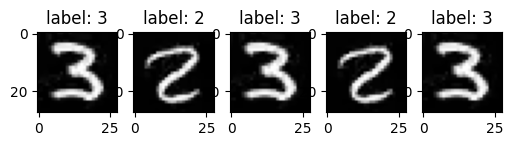

In [6]:
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[6,8])

for axi in ax.flat:
    idx = np.random.randint(len(response))
    img = response['mnistvid.data'].iloc[idx]
    label = response['mnistimageclassifier.label'].iloc[idx]
    axi.imshow(img)
    
    axi.set_title(f'label: {label}')

plt.show()